In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import time
from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.greedy_agent import GreedyAgent
from agentfil import constants
from mechafil import minting, sim

from scipy.stats import rankdata, kendalltau, pearsonr
from scipy.special import expit

import numpyro
from pycoingecko import CoinGeckoAPI

In [3]:
NDEVICES=2
numpyro.set_host_device_count(NDEVICES)

data_start_date = date(2021, 3, 15)
n_months_offset = 12
simulation_start_date = datetime.today().date() - timedelta(days=1)
end_date = simulation_start_date + timedelta(days=360)

In [4]:
cg = CoinGeckoAPI()
id_ = 'filecoin'
change_t = lambda x : datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d')
ts = cg.get_coin_market_chart_range_by_id(id=id_,
                                          vs_currency='usd',
                                          from_timestamp=time.mktime(constants.NETWORK_DATA_START.timetuple()),
                                          to_timestamp=time.mktime((simulation_start_date-timedelta(days=1)).timetuple()))

usd_fil_exchange_df = pd.DataFrame(
    {
        "coin" : id_,
        "date" : list(map(change_t, np.array(ts['prices']).T[0])),
        "price" : np.array(ts['prices']).T[1],
        "market_caps" : np.array(ts['market_caps']).T[1], 
        "total_volumes" : np.array(ts['total_volumes']).T[1]
    }
)
usd_fil_exchange_df['date'] = pd.to_datetime(usd_fil_exchange_df['date']).dt.date

In [5]:
def pobs(X):
    # X.shape = (n,d), n = # of samples, d = dimension of data
    n, d = X.shape
    U = rankdata(X, method='ordinal', axis=0) / float(n+1)  # divide by n+1 to mitigate boundary errors
    return U

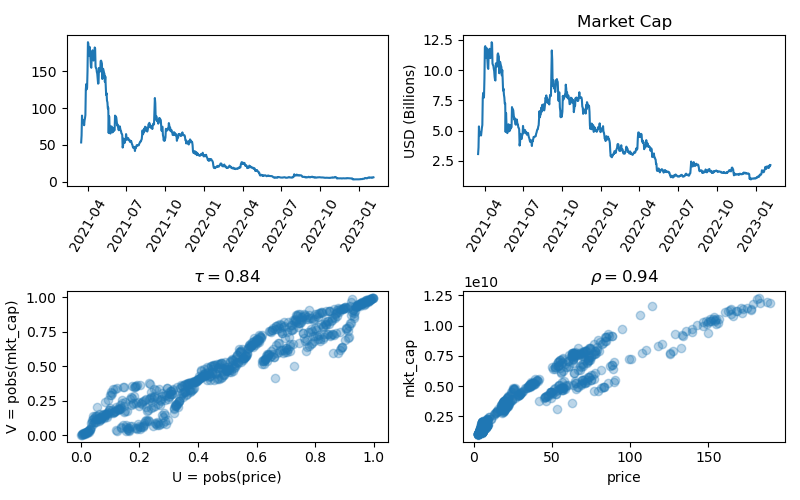

In [6]:
plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
plt.plot(usd_fil_exchange_df['date'], usd_fil_exchange_df['price'])
plt.xticks(rotation=60)

plt.subplot(2,2,2)
plt.plot(usd_fil_exchange_df['date'], usd_fil_exchange_df['market_caps']/1e9)
plt.xticks(rotation=60)
plt.ylabel('USD (Billions)')
plt.title('Market Cap')

X = np.vstack([usd_fil_exchange_df['price'].values, usd_fil_exchange_df['market_caps'].values]).T
ktau = kendalltau(X[:,0], X[:,1]).correlation
U = pobs(X)
plt.subplot(2,2,3)
plt.scatter(U[:,0], U[:,1], alpha=0.3)
plt.xlabel('U = pobs(price)')
plt.ylabel('V = pobs(mkt_cap)')
plt.title(r'$\tau=%0.02f$' % (ktau,))

plt.subplot(2,2,4)
plt.scatter(X[:,0], X[:,1], alpha=0.3)
plt.xlabel('price')
plt.ylabel('mkt_cap')
rr = pearsonr(X[:,0], X[:,1])
plt.title(r'$\rho=%0.02f$' % (rr.statistic,))


plt.tight_layout()

In [7]:
rr = 0.6
rbp = 10
fpr = 0.6
sector_duration = 360
forecast_length=540
mechafil_df = sim.run_simple_sim(
    data_start_date,
    simulation_start_date,
    forecast_length,
    rr,
    rbp,
    fpr,
    sector_duration,
    qap_method = 'basic' # can be set to tunable or basic
                         # see: https://hackmd.io/O6HmAb--SgmxkjLWSpbN_A?view
)

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [8]:
# def add_generated_quantities(df:pd.DataFrame)->pd.DataFrame:
#     # add ROI to trajectory df
#     duration = 360
#     GIB = 2 ** 30
#     SECTOR_SIZE = 32 * GIB
    
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * (df['day_locked_pledge']-df['day_renewed_pledge'])/(df['day_onboarded_power_QAP'])
#     df['day_rewards_per_sector'] = SECTOR_SIZE * df.day_network_reward / df.network_QAP
#     df['1y_return_per_sector'] = df['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
#     df['1y_sector_roi'] = df['1y_return_per_sector'] / df['day_pledge_per_QAP']
    
#     return df

In [9]:
# mechafil_df = add_generated_quantities(mechafil_df)
merged_df = mechafil_df.merge(usd_fil_exchange_df, on='date', how='inner').dropna()

In [10]:
# prepare data for classification
EIB = 2**60

# classifier_data = merged_df[['date', 'circ_supply', 'network_locked', 'network_QAP',  
#                              'day_pledge_per_QAP', 'day_rewards_per_sector',
#                              '1y_sector_roi',
#                              'market_caps', 'price']]
# classifier_data['network_QAP'] = classifier_data['network_QAP'] / EIB
# classifier_data['qap_grad'] = classifier_data['network_QAP'].diff()
# classifier_data['market_cap_growth_rate'] = classifier_data['market_caps'].diff()/classifier_data['market_caps']

# classifier_data = classifier_data.dropna()
# classifier_data['locked_div_supply'] = classifier_data['network_locked'] / classifier_data['circ_supply']

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, TimeSeriesSplit

from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.neural_network import MLPRegressor

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
class MultiplyXform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['mkt_cap_crude'] = X['price'] * X['circ_supply']
        out = X[['mkt_cap_crude']].values
        if len(out) == 1:
            out = out.reshape(1,-1)
        return out

In [13]:
# Test a few classifiers
names = [
    'Robust', 
    'Standard',
    'Normalizer',
    'MinMax',
    'MaxAbs'
]
classifiers = [
    make_pipeline(MultiplyXform(), RobustScaler(), SGDRegressor(max_iter=1000, tol=1e-3)),
    make_pipeline(MultiplyXform(), StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3)),
    make_pipeline(MultiplyXform(), Normalizer(), SGDRegressor(max_iter=1000, tol=1e-3)),
    make_pipeline(MultiplyXform(), MinMaxScaler(), SGDRegressor(max_iter=1000, tol=1e-3)),
    make_pipeline(MultiplyXform(), MaxAbsScaler(), SGDRegressor(max_iter=1000, tol=1e-3)),
]

# X = classifier_data[['locked_div_supply', 'network_QAP', 'qap_grad', 
#                      'day_pledge_per_QAP', 'day_rewards_per_sector', 
#                      '1y_sector_roi',
#                      'price']]
# X = classifier_data[['price', 'circ_supply', 'locked_div_supply', 
#                      'network_QAP', 'qap_grad', 'day_pledge_per_QAP', 
#                      'day_rewards_per_sector']]
# X['crude_pred'] = classifier_data['price'] * classifier_data['circ_supply']

# X_in = X[['crude_pred']]  # a cursory check indicates that other features degrade classifier performance
X_in = merged_df[['circ_supply', 'price']]
y_in = merged_df['market_caps']
tscv = TimeSeriesSplit()

def evaluate(model, in_X, in_y, cv):
    cv_results = cross_validate(model, in_X, in_y, cv=cv, scoring='r2')
    return cv_results

for name, clf in zip(names, classifiers):
    cv_results = evaluate(clf, X_in, y_in, tscv)
    print(name, cv_results['test_score'], np.mean(cv_results['test_score']))
    
# X_train , X_test , y_train, y_test = train_test_split(X, y, random_state=0)
# for name, clf in zip(names, classifiers):
#     clf.fit(X_train.values, y_train.values)
#     score = clf.score(X_test.values, y_test.values)
#     print(name, score)

Robust [0.91241148 0.96638989 0.97112054 0.7959373  0.8851239 ] 0.9061966225343703
Standard [0.91217581 0.96598841 0.97134486 0.79419732 0.88485166] 0.9057116123639144
Normalizer [-1.31807164e-01 -1.81498922e+00 -1.21408635e+01 -1.66888606e+02
 -1.33421257e+02] -62.87950456188382
MinMax [0.91276971 0.97216332 0.96975747 0.7003959  0.8856709 ] 0.8881514613217073
MaxAbs [0.91877163 0.97430033 0.96581197 0.73316534 0.88560059] 0.895529970215264


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [14]:
# debug the implementation in the codebase
import pickle
with open('data_in.pkl', 'rb') as f:
    z = pickle.load(f)
codebase_X = z['X']
codebase_X['price'] = codebase_X['price_Q50']
codebase_X = codebase_X.drop(['price_Q50'], axis=1)
codebase_y = z['y']

evaluate(classifiers[0], codebase_X, codebase_y, tscv)

{'fit_time': array([0.00274992, 0.0013597 , 0.00133491, 0.00189996, 0.00215292]),
 'score_time': array([0.00060225, 0.00056815, 0.00056219, 0.00056815, 0.0005579 ]),
 'test_score': array([ 0.72199207,  0.9112593 ,  0.90009262, -0.04222558,  0.66287213])}

In [15]:
m1 = make_pipeline(MultiplyXform(), 
                   RobustScaler(), 
                   SGDRegressor(max_iter=1000, tol=1e-3))

m2 = make_pipeline(MultiplyXform(), 
                   RobustScaler(), 
                   SGDRegressor(max_iter=1000, tol=1e-3))
# fit on all data 
m1.fit(X_in, y_in)
m2.fit(codebase_X, codebase_y)

Pipeline(steps=[('multiplyxform', MultiplyXform()),
                ('robustscaler', RobustScaler()),
                ('sgdregressor', SGDRegressor())])

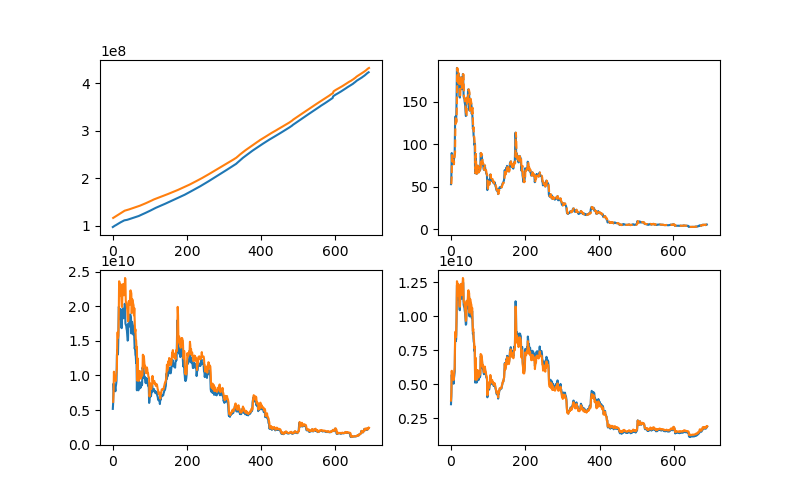

In [16]:
plt.figure(figsize=(8,5))

plt.subplot(2,2,1)
plt.plot(X_in['circ_supply'])
plt.plot(codebase_X['circ_supply'])

plt.subplot(2,2,2)
plt.plot(X_in['price'])
plt.plot(codebase_X['price'], linestyle='--')

plt.subplot(2,2,3)
plt.plot(X_in['circ_supply'] * X_in['price'])
plt.plot(codebase_X['circ_supply'] * codebase_X['price'])

plt.subplot(2,2,4)
# plt.plot(y_in)
# plt.plot(codebase_y, linestyle='--')
plt.plot(m1.predict(X_in))
plt.plot(m2.predict(codebase_X))

In [17]:
market_cap_prediction_model = make_pipeline(MultiplyXform(), 
                                            StandardScaler(), 
                                            SGDRegressor(max_iter=1000, tol=1e-3))
market_cap_prediction_model.fit(X_in, y_in)  # train on full data for usage

# model will be used in a time-series fashion, even though it isn't a time-series model b/c it
# uses inputs to predict market cap rather than the structure of the time-series.
# we use it in a time-series fashion because we map the market-cap growth rate to capital inflow

Pipeline(steps=[('multiplyxform', MultiplyXform()),
                ('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [18]:
# Define the capital-inflow model
def capital_inflow_model(mkt_cap_growth_vec, current_circ_supply):
    """
    Inputs:
      - market cap growth rate vector - should be a history of n previous market-cap-growth values
      - current circulating supply
    Output:
      - The amount of FIL that will be inflowed into SPs as capital
    """
    # define the filter
    h = np.ones(len(mkt_cap_growth_vec))/len(mkt_cap_growth_vec)
    mkt_cap_growth_smoothed = np.sum(np.multiply(mkt_cap_growth_vec, h))
    
    # apply sigmoid function to convert to percentage of infil, 0 means no-new infil
    capital_inflow_pct = expit(mkt_cap_growth_smoothed)
    return capital_inflow_pct * current_circ_supply

In [19]:
# Demonstrate Usage of the model
example_df = copy.copy(merged_df)
example_df['market_cap_pred'] = 0
example_df['market_cap_growth'] = 0
example_df['fil_inflow'] = 0
example_df['network_QAP'] = example_df['network_QAP'] / EIB
example_df['qap_grad'] = example_df['network_QAP'].diff()
example_df['locked_div_supply'] = example_df['network_locked'] / example_df['circ_supply']

for ii, row in example_df.iterrows():
    X = row[['circ_supply', 'price']]
    mkt_cap_pred = market_cap_prediction_model.predict(X)
    example_df.loc[ii, 'market_cap_pred'] = mkt_cap_pred


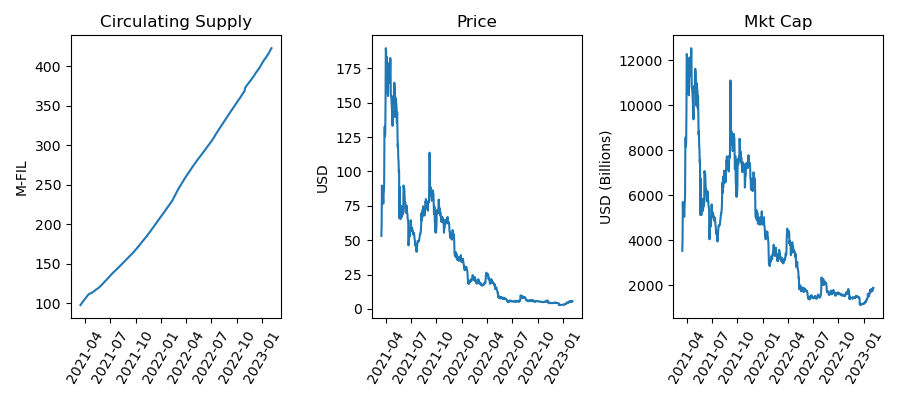

In [20]:
plt.figure(figsize=(9,4))

plt.subplot(1,3,1)
plt.plot(example_df['date'], example_df['circ_supply']/1_000_000)
plt.xticks(rotation=60)
plt.ylabel('M-FIL')
plt.title('Circulating Supply')

plt.subplot(1,3,2)
plt.plot(example_df['date'], example_df['price'])
plt.xticks(rotation=60)
plt.ylabel('USD')
plt.title('Price')

plt.subplot(1,3,3)
plt.plot(example_df['date'], example_df['market_cap_pred']/1_000_000)
plt.xticks(rotation=60)
plt.ylabel('USD (Billions)')
plt.title('Mkt Cap')

plt.tight_layout()

In [25]:
class Controller:
    def __init__(self, p=0.1, i=0.1, d=0.1, setpoint=0.5):
        self.p = p
        self.i = i
        self.d = d
        
        self.setpoint = setpoint
        
        self.err_sum = 0 
        self.last_err = 0
        
    def change_setpoint(self, p):
        self.setpoint = p
        
    def step(self, v):
        # v is the current value
        # setpoint is our target
        
        err = self.setpoint - v  # if v is less, err is +, if v is more, err is -
        self.err_sum += err
        d_err = err - self.last_err
        
        output = v + (err * self.p) + (self.i * self.err_sum) + (self.d * d_err)
        self.last_err = err
        return output

In [32]:
p = 0.1
i = 0.01
d = 0.01
c = Controller(p, i, d)
setpoints = np.random.choice([0, 0.0025, 0.005, .01], size=(200,))
v = 0

outputs = []
for sp in setpoints:
    c.change_setpoint(sp)
    v = c.step(v)
    
    outputs.append(v)

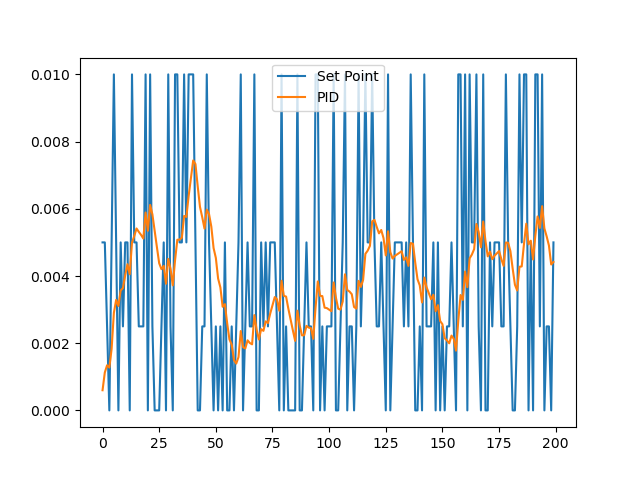

In [33]:
plt.figure()
plt.plot(setpoints, label='Set Point')
plt.plot(outputs, label='PID')
plt.legend()

In [24]:
pd.DataFrame({'circ_supply': [1], 'price': [2]})

,circ_supply,price
0,1,2
